Libraries:

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading Dataset:

In [3]:
RUL = pd.read_csv('/content/drive/MyDrive/RUL_FD001.csv')
train = pd.read_csv('/content/drive/MyDrive/train_FD001.csv')
test = pd.read_csv('/content/drive/MyDrive/test_FD001.csv')

In [4]:
train.head()

,Unnamed: 0,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#Data Pre-processing:

##Data Selection:

In [5]:
col = ['operational setting 3', 'sensor measurement 1', 'sensor measurement 5', 'sensor measurement 10', 'sensor measurement 16', 'sensor measurement 19']
train = train.drop(columns=col)
test = test.drop(columns=col)

##Normalization:

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
col_n = [col for col in train.columns if col.startswith('operational setting') or col.startswith('sensor measurement')]

scaler = MinMaxScaler()
train[col_n] = scaler.fit_transform(train[col_n])
test[col_n] = scaler.fit_transform(test[col_n])

##Labeling:

In [8]:
threshold = 130
win_size = 30

regression_labels = []
classification_labels = []

regression_labels_t = []
classification_labels_t = []

unit_counts = train['unit number'].value_counts().sort_index()
for count in unit_counts:
    ruls = [min(threshold, count - i - 1) for i in range(count)]
    regression_labels += ruls
    classification_labels += [int(rul <= win_size) for rul in ruls]

unit_counts = test['unit number'].value_counts().sort_index()
for count in unit_counts:
    ruls = [min(threshold, count - i - 1) for i in range(count)]
    regression_labels_t += ruls
    classification_labels_t += [int(rul <= win_size) for rul in ruls]

##Timing Window:

In [9]:
windows = []
regression_window = []
classification_window = []


for i in range(len(train) - win_size + 1):
    window = train.iloc[i: i + win_size]

    if window['unit number'].nunique() == 1:
        window = window.drop(columns=['Unnamed: 0', 'unit number', 'time in cycles'])
        windows.append(window.values)
        regression_window.append(regression_labels[i + win_size - 1])
        classification_window.append(classification_labels[i + win_size - 1])



In [10]:
X_train = windows
y_train_reg = regression_window
y_train_class = classification_window

##Test Pre-processing:

In [11]:
regression_labels = []
classification_labels = []

unit_counts = test['unit number'].value_counts().sort_index()
for count in unit_counts:
    ruls = [min(threshold, count - i - 1) for i in range(count)]
    regression_labels += ruls
    classification_labels += [int(rul <= win_size) for rul in ruls]


windows = []

regression_window = []
classification_window = []

X_test_reg_last = []
y_test_reg_last = []
unit_off = 1


for i in range(len(test) - win_size + 1):
    window = test.iloc[i: i + win_size]
    unit_on = window.iloc[-1]['unit number']

    if window['unit number'].nunique() == 1:
        window = window.drop(columns=['Unnamed: 0', 'unit number', 'time in cycles'])
        windows.append(window.values)
        regression_window.append(regression_labels[i + win_size - 1])
        classification_window.append(classification_labels[i + win_size - 1])

        if unit_on != unit_off:
          X_test_reg_last.append(windows[-1])
          y_test_reg_last.append(regression_window[-1])
          unit_off = unit_on

X_test = windows
y_test_reg = regression_window
y_test_class = classification_window

##Validation:

In [12]:
from sklearn.model_selection import train_test_split


validation_split = 0.2

X_train_class, X_val, y_train_class, y_val = train_test_split(X_train, y_train_class, test_size=validation_split, random_state=42)

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_train, y_train_reg, test_size=validation_split, random_state=42)


In [13]:
import tensorflow as tf
X_train_class = tf.convert_to_tensor(X_train_class)
X_val = tf.convert_to_tensor(X_val)

# Modelization:

##Classification (Without Early Stopping):

Libraries:

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import numpy as np

In [16]:
y_train_class = np.array(y_train_class)
y_val = np.array(y_val)

In [17]:
input_shape = (30, 18)
inputs = Input(shape=input_shape)

x = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)

x = LSTM(units=50, activation='tanh', return_sequences=True)(x)
x = Dropout(rate=0.2)(x)

x = LSTM(units=50, activation='tanh')(x)
x = Dropout(rate=0.2)(x)

classification_output = Dense(units=1, activation='sigmoid', name='classification_output')(x)

model = Model(inputs=inputs, outputs=classification_output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 18)]          0         
                                                                 
 conv1d (Conv1D)             (None, 26, 32)            2912      
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            6208      
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 64)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 8, 50)             23000     
                                                                 
 dropout (Dropout)           (None, 8, 50)             0         
                                                             

In [18]:
history = model.fit(X_train_class, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
444/444 [==============================] - 16s 14ms/step - loss: 0.2835 - accuracy: 0.8909 - precision: 0.8026 - recall: 0.5026 - auc: 0.9010 - val_loss: 0.1779 - val_accuracy: 0.9244 - val_precision: 0.8199 - val_recall: 0.7176 - val_auc: 0.9667
Epoch 2/100
444/444 [==============================] - 4s 9ms/step - loss: 0.1816 - accuracy: 0.9254 - precision: 0.8053 - recall: 0.7587 - auc: 0.9635 - val_loss: 0.1657 - val_accuracy: 0.9275 - val_precision: 0.7983 - val_recall: 0.7734 - val_auc: 0.9706
Epoch 3/100
444/444 [==============================] - 5s 11ms/step - loss: 0.1710 - accuracy: 0.9290 - precision: 0.8220 - recall: 0.7603 - auc: 0.9679 - val_loss: 0.1557 - val_accuracy: 0.9301 - val_precision: 0.8276 - val_recall: 0.7488 - val_auc: 0.9736
Epoch 4/100
444/444 [==============================] - 5s 11ms/step - loss: 0.1571 - accuracy: 0.9348 - precision: 0.8407 - recall: 0.7756 - auc: 0.9727 - val_loss: 0.1349 - val_accuracy: 0.9408 - val_precision: 0.8265 - val_r

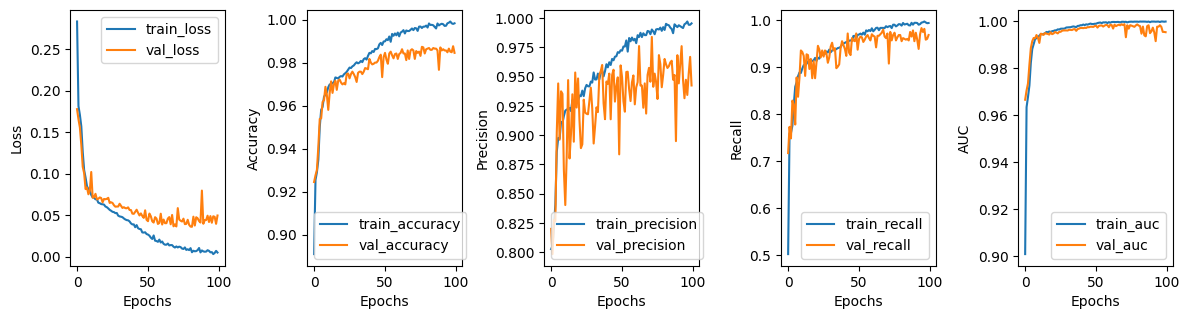

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss
plt.subplot(2, 5, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 5, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 5, 3)
plt.plot(history.history['precision'], label='train_precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 5, 4)
plt.plot(history.history['recall'], label='train_recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(2, 5, 5)
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

Test:

In [20]:
y_test_class = np.array(y_test_class)
X_test = tf.convert_to_tensor(X_test)

y_pred = model.predict(X_test)

319/319 [==============================] - 2s 3ms/step


Accuracy, F1-score, Recall and Precision:

In [21]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [22]:
y_pred_classes = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test_class, y_pred_classes)
f1 = f1_score(y_test_class, y_pred_classes)
recall = recall_score(y_test_class, y_pred_classes)
precision = precision_score(y_test_class, y_pred_classes)

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.7645154962730483
F1-score: 0.4162411864818867
Recall: 0.2918513467439482
Precision: 0.7254237288135593


Confusion Matrix:

Normalized confusion matrix


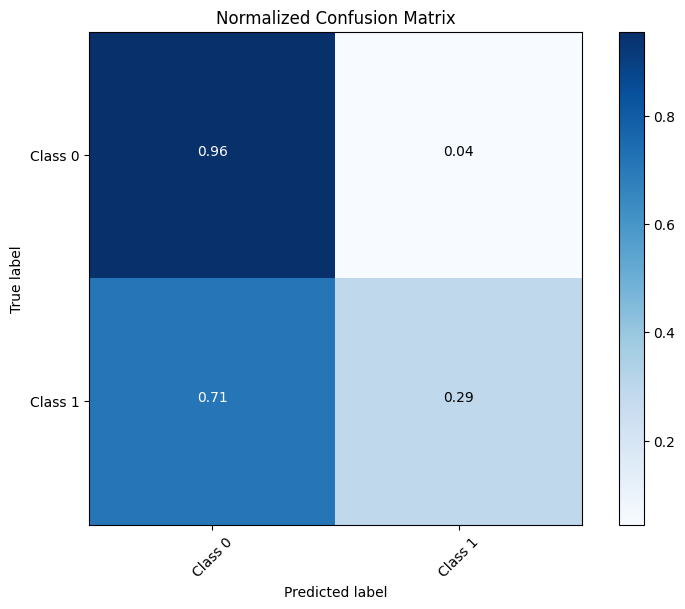

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



conf_matrix = confusion_matrix(y_test_class, y_pred_classes)

class_labels = ["Class 0", "Class 1"]

plot_confusion_matrix(conf_matrix, classes=class_labels, normalize=True, title='Normalized Confusion Matrix')

plt.show()


ROC:

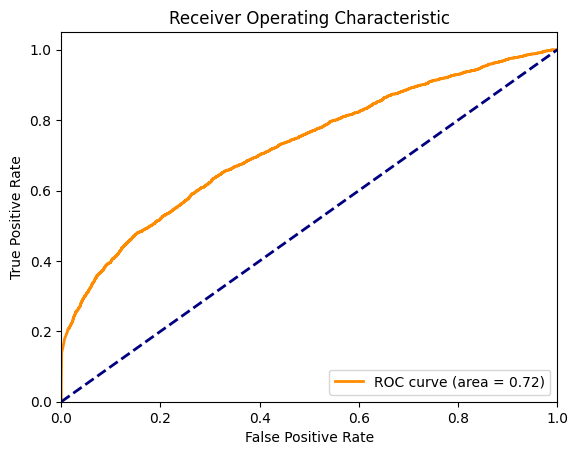

In [24]:
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##Classification (With Early-Stopping):

In [25]:
input_shape = (30, 18)
inputs = Input(shape=input_shape)

x = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)

x = LSTM(units=50, activation='tanh', return_sequences=True)(x)
x = Dropout(rate=0.2)(x)

x = LSTM(units=50, activation='tanh')(x)
x = Dropout(rate=0.2)(x)

classification_output = Dense(units=1, activation='sigmoid', name='classification_output')(x)

model = Model(inputs=inputs, outputs=classification_output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 18)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 26, 32)            2912      
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 8, 64)             0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 8, 50)             23000     
                                                                 
 dropout_2 (Dropout)         (None, 8, 50)             0         
                                                           

In [26]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_class, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks = [early_stopping])

Epoch 1/100
444/444 [==============================] - 10s 12ms/step - loss: 0.2964 - accuracy: 0.8830 - precision_1: 0.7945 - recall_1: 0.4500 - auc_1: 0.8883 - val_loss: 0.1825 - val_accuracy: 0.9264 - val_precision_1: 0.8580 - val_recall_1: 0.6847 - val_auc_1: 0.9691
Epoch 2/100
444/444 [==============================] - 4s 9ms/step - loss: 0.1797 - accuracy: 0.9265 - precision_1: 0.8073 - recall_1: 0.7635 - auc_1: 0.9648 - val_loss: 0.1779 - val_accuracy: 0.9222 - val_precision_1: 0.7290 - val_recall_1: 0.8703 - val_auc_1: 0.9720
Epoch 3/100
444/444 [==============================] - 4s 9ms/step - loss: 0.1697 - accuracy: 0.9294 - precision_1: 0.8164 - recall_1: 0.7712 - auc_1: 0.9688 - val_loss: 0.1589 - val_accuracy: 0.9306 - val_precision_1: 0.7832 - val_recall_1: 0.8243 - val_auc_1: 0.9745
Epoch 4/100
444/444 [==============================] - 4s 10ms/step - loss: 0.1594 - accuracy: 0.9327 - precision_1: 0.8334 - recall_1: 0.7712 - auc_1: 0.9722 - val_loss: 0.1464 - val_accurac

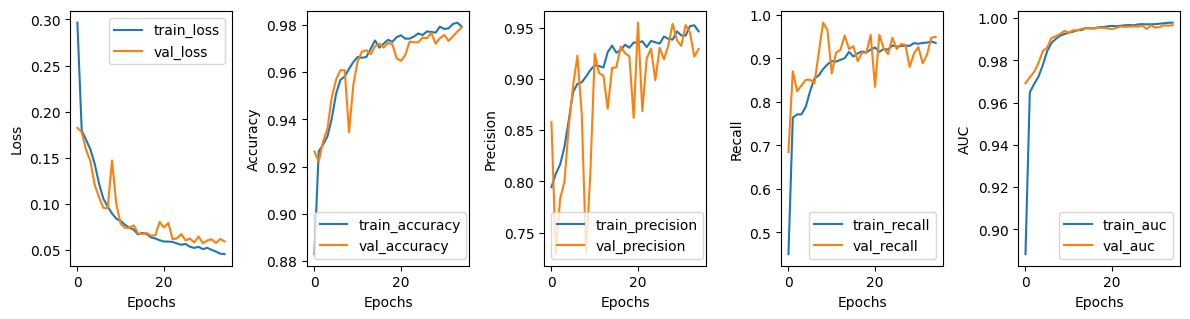

In [27]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(2, 5, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 5, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 5, 3)
plt.plot(history.history['precision_1'], label='train_precision')
plt.plot(history.history['val_precision_1'], label='val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 5, 4)
plt.plot(history.history['recall_1'], label='train_recall')
plt.plot(history.history['val_recall_1'], label='val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(2, 5, 5)
plt.plot(history.history['auc_1'], label='train_auc')
plt.plot(history.history['val_auc_1'], label='val_auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

Test:

In [28]:
y_pred = model.predict(X_test)

319/319 [==============================] - 2s 3ms/step


Accuracy, F1-score, Recall and Precision:

In [29]:
y_pred_classes = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test_class, y_pred_classes)
f1 = f1_score(y_test_class, y_pred_classes)
recall = recall_score(y_test_class, y_pred_classes)
precision = precision_score(y_test_class, y_pred_classes)

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.765300117693213
F1-score: 0.42128174123337364
Recall: 0.2969655642686669
Precision: 0.7246256239600666


Confusion Matrix:

Normalized confusion matrix


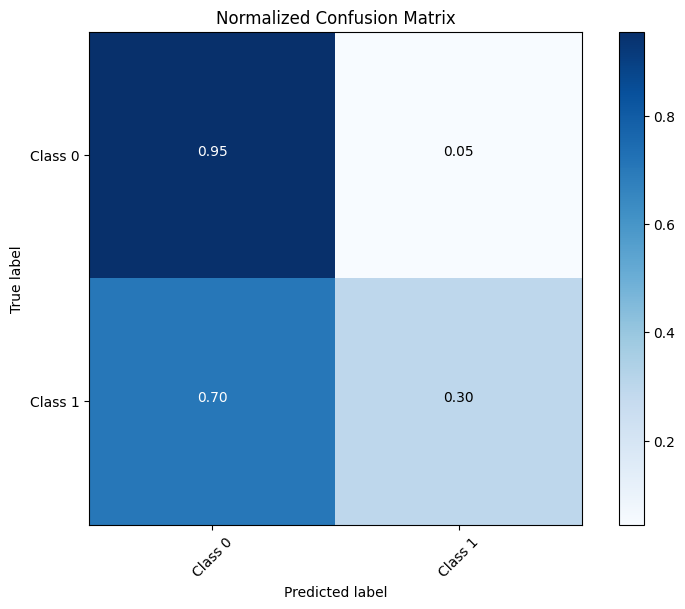

In [30]:
conf_matrix = confusion_matrix(y_test_class, y_pred_classes)

class_labels = ["Class 0", "Class 1"]

plot_confusion_matrix(conf_matrix, classes=class_labels, normalize=True, title='Normalized Confusion Matrix')

plt.show()

ROC:

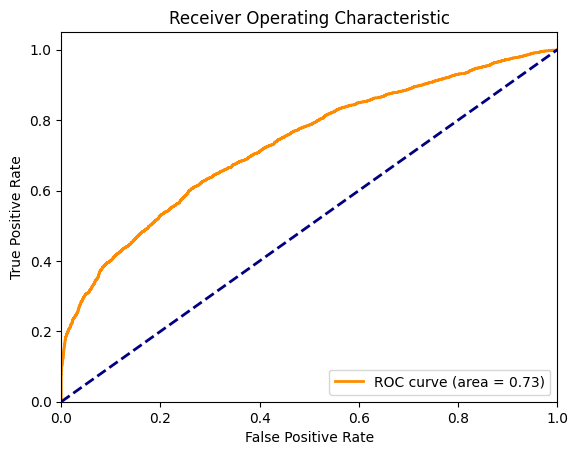

In [31]:
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##Regression (Without Early-Stopping):

Model:

In [17]:
input_shape = (30, 18)
inputs = Input(shape=input_shape)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(rate=0.2)(x)

x = LSTM(units=50)(x)
x = Dropout(rate=0.2)(x)

x = Dense(units=50, activation='relu')(x)
output = Dense(units=1, activation='linear')(x)

model_2 = Model(inputs=inputs, outputs=output)
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 18)]          0         
                                                                 
 conv1d (Conv1D)             (None, 28, 32)            1760      
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            6208      
                                                                 
 max_pooling1d (MaxPooling1  (None, 13, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 13, 50)            23000     
                                                                 
 dropout (Dropout)           (None, 13, 50)            0         
                                                             

In [18]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model_2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

X_train_reg = np.array(X_train_reg)
y_train_reg = np.array(y_train_reg)

X_val_reg = np.array(X_val_reg)
y_val_reg = np.array(y_val_reg)

history = model_2.fit(X_train_reg, y_train_reg, epochs=100, batch_size=32, validation_data=(X_val_reg, y_val_reg))


Epoch 1/100
444/444 [==============================] - 13s 10ms/step - loss: 2202.7480 - mae: 37.9139 - val_loss: 499.3437 - val_mae: 18.4162
Epoch 2/100
444/444 [==============================] - 4s 9ms/step - loss: 506.3159 - mae: 17.6569 - val_loss: 672.7961 - val_mae: 20.1254
Epoch 3/100
444/444 [==============================] - 5s 11ms/step - loss: 373.8928 - mae: 14.9437 - val_loss: 534.4968 - val_mae: 16.7529
Epoch 4/100
444/444 [==============================] - 4s 8ms/step - loss: 335.0680 - mae: 14.0342 - val_loss: 275.1375 - val_mae: 12.3142
Epoch 5/100
444/444 [==============================] - 4s 8ms/step - loss: 308.1214 - mae: 13.4228 - val_loss: 310.2328 - val_mae: 13.5869
Epoch 6/100
444/444 [==============================] - 5s 11ms/step - loss: 289.4450 - mae: 12.8841 - val_loss: 230.1383 - val_mae: 11.3889
Epoch 7/100
444/444 [==============================] - 4s 9ms/step - loss: 274.2229 - mae: 12.5268 - val_loss: 238.1419 - val_mae: 12.0871
Epoch 8/100
444/444 [=

In [19]:
X_test_class = np.array(X_test)
y_test_reg = np.array(y_test_reg)

y_pred_2 = model_2.predict(X_test_class)


319/319 [==============================] - 2s 4ms/step


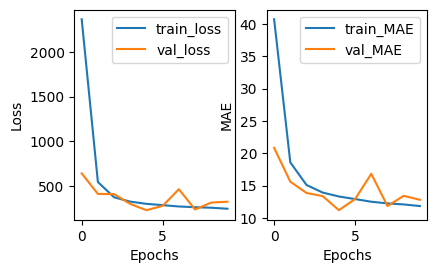

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss
plt.subplot(2, 5, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE
plt.subplot(2, 5, 2)
plt.plot(history.history['mae'], label='train_MAE')
plt.plot(history.history['val_mae'], label='val_MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()


RMSE, MSE , MAE, MAPE:

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [39]:
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_2))
mse = mean_squared_error(y_test_reg, y_pred_2)
mae = mean_absolute_error(y_test_reg, y_pred_2)
mape = np.mean(np.abs((y_test_reg - y_pred_2) / (y_test_reg + 1.e-6))) / len(y_test_reg)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 39.28481016984262
MSE: 1543.2963100805703
MAE: 31.603515754638348
MAPE: 65.16499586484004


RUL Plot:

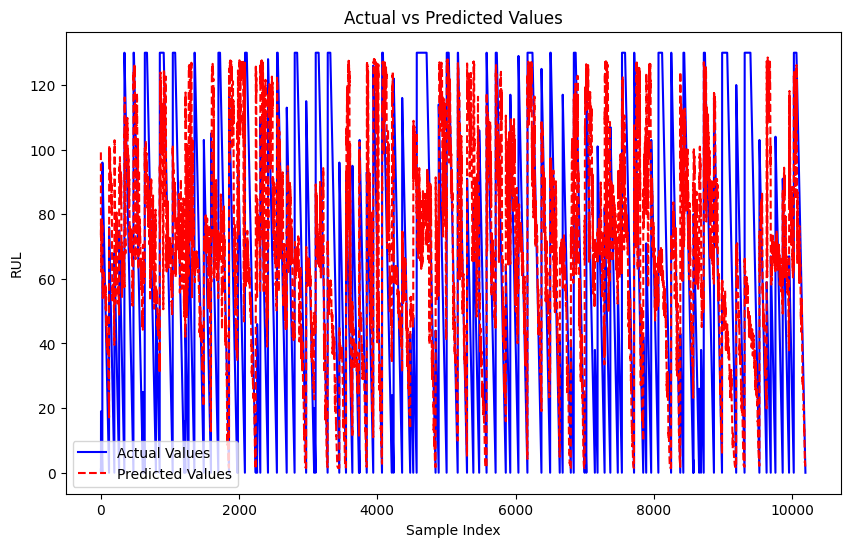

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_reg, label='Actual Values', color='b')
plt.plot(y_pred_2, label='Predicted Values', color='r', linestyle='--')

plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('RUL')

plt.legend()

plt.show()

##Last Window:

In [40]:
X_test_reg_last = np.array(X_test_reg_last)
y_test_reg_last = np.array(y_test_reg_last)

y_pred_3 = model_2.predict(X_test_reg_last)

4/4 [==============================] - 0s 5ms/step


RMSE, MSE , MAE, MAPE:

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [42]:
rmse = np.sqrt(mean_squared_error(y_test_reg_last, y_pred_3))
mse = mean_squared_error(y_test_reg_last, y_pred_3)
mae = mean_absolute_error(y_test_reg_last, y_pred_3)
mape = np.mean(np.abs((y_test_reg_last - y_pred_3) / y_test_reg_last)) / len(y_test_reg_last)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 44.28933821796972
MSE: 1961.5454797857135
MAE: 37.79364822850083
MAPE: 0.010469453197321968


RUL Plot:

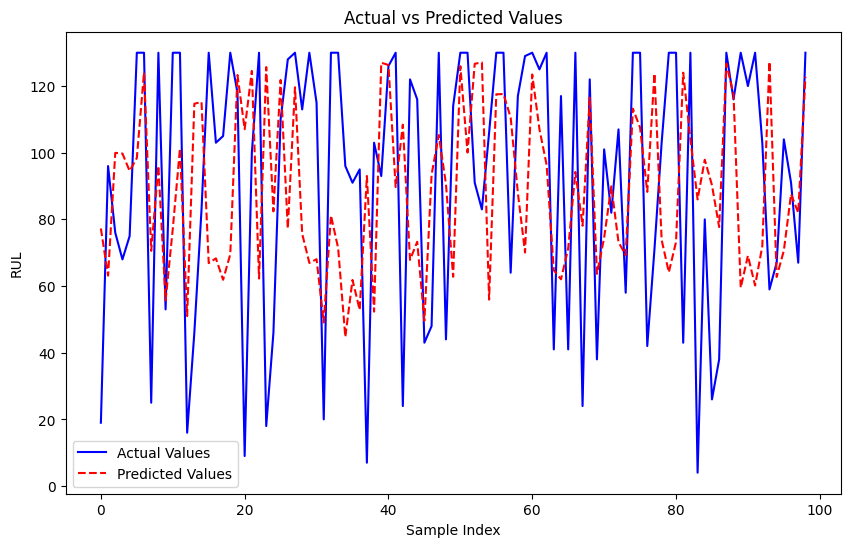

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_reg_last, label='Actual Values', color='b')
plt.plot(y_pred_3, label='Predicted Values', color='r', linestyle='--')

plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('RUL')

plt.legend()

plt.show()

## Regression (With Early-Stopping):

Model:

In [45]:
input_shape = (30, 18)
inputs = Input(shape=input_shape)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(rate=0.2)(x)

x = LSTM(units=50)(x)
x = Dropout(rate=0.2)(x)

x = Dense(units=50, activation='relu')(x)
output = Dense(units=1, activation='linear')(x)

model_3 = Model(inputs=inputs, outputs=output)
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 18)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 28, 32)            1760      
                                                                 
 conv1d_5 (Conv1D)           (None, 26, 64)            6208      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 13, 50)            23000     
                                                                 
 dropout_4 (Dropout)         (None, 13, 50)            0         
                                                           

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model_3.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_3.fit(X_train_reg, y_train_reg, epochs=100, batch_size=32, validation_data=(X_val_reg, y_val_reg), callbacks = [early_stopping])


Epoch 1/100
444/444 [==============================] - 9s 10ms/step - loss: 3094.2886 - mae: 46.9404 - val_loss: 1875.5063 - val_mae: 38.4945
Epoch 2/100
444/444 [==============================] - 4s 10ms/step - loss: 1914.6593 - mae: 38.6883 - val_loss: 1872.1342 - val_mae: 38.1517
Epoch 3/100
444/444 [==============================] - 4s 8ms/step - loss: 1347.7476 - mae: 30.9779 - val_loss: 649.7396 - val_mae: 20.5557
Epoch 4/100
444/444 [==============================] - 3s 8ms/step - loss: 464.7318 - mae: 16.9949 - val_loss: 573.9603 - val_mae: 18.4587
Epoch 5/100
444/444 [==============================] - 4s 9ms/step - loss: 370.0591 - mae: 14.9248 - val_loss: 347.1449 - val_mae: 13.0398
Epoch 6/100
444/444 [==============================] - 4s 10ms/step - loss: 329.9503 - mae: 13.9283 - val_loss: 301.5848 - val_mae: 12.6230
Epoch 7/100
444/444 [==============================] - 3s 8ms/step - loss: 308.3952 - mae: 13.4588 - val_loss: 276.8516 - val_mae: 12.6958
Epoch 8/100
444/444

In [47]:
X_test_class = np.array(X_test)
y_test_reg = np.array(y_test_reg)

y_pred_3 = model_3.predict(X_test_class)

319/319 [==============================] - 2s 3ms/step


RMSE, MSE , MAE, MAPE:

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [57]:
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_3))
mse = mean_squared_error(y_test_reg, y_pred_3)
mae = mean_absolute_error(y_test_reg, y_pred_3)
mape = np.mean(np.abs((y_test_reg - y_pred_3) / (y_test_reg + 1.e-5))) / len(y_test_reg)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 39.47585204566809
MSE: 1558.3428947314778
MAE: 31.196377070804072
MAPE: 6.529267098853645


RUL Plot:

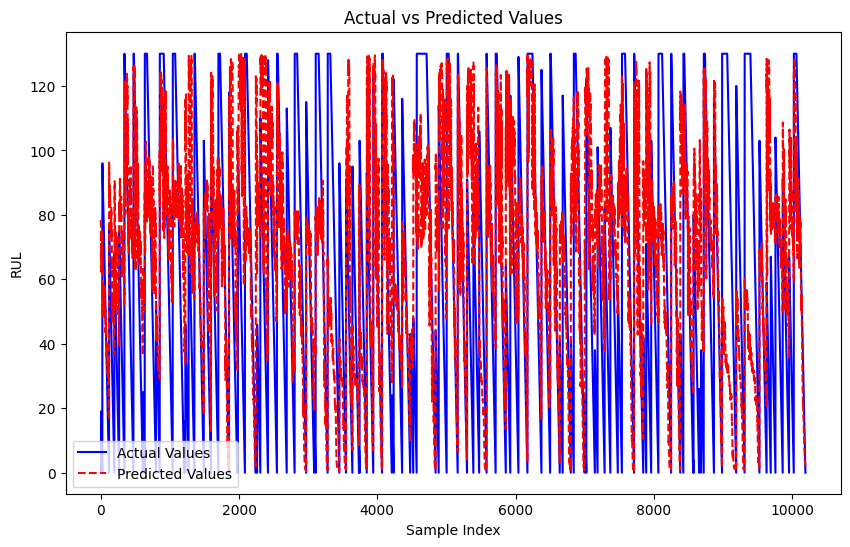

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_reg, label='Actual Values', color='b')
plt.plot(y_pred_3, label='Predicted Values', color='r', linestyle='--')

plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('RUL')

plt.legend()

plt.show()

## Last Window:

In [51]:
y_pred_4 = model_3.predict(X_test_reg_last)


4/4 [==============================] - 0s 4ms/step


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [53]:
rmse = np.sqrt(mean_squared_error(y_test_reg_last, y_pred_4))
mse = mean_squared_error(y_test_reg_last, y_pred_4)
mae = mean_absolute_error(y_test_reg_last, y_pred_4)
mape = np.mean(np.abs((y_test_reg_last - y_pred_4) / y_test_reg_last)) / len(y_test_reg_last)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 42.5277529599199
MSE: 1808.6097718199758
MAE: 35.3338412275218
MAPE: 0.010639659398591335


RUL Plot:

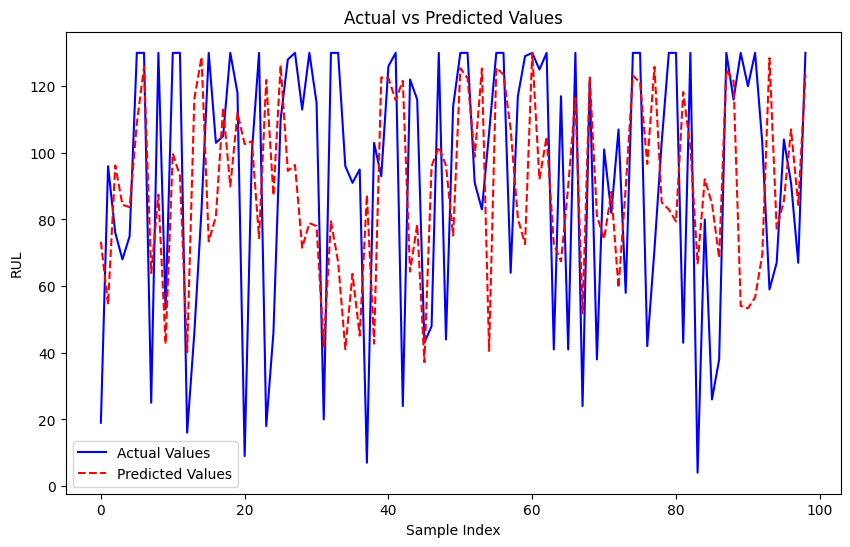

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_reg_last, label='Actual Values', color='b')
plt.plot(y_pred_4, label='Predicted Values', color='r', linestyle='--')

plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('RUL')

plt.legend()

plt.show()

#Comparing with Fundemental Model:

##LSTM for Classification:

In [52]:
import tensorflow as tf

input_shape = (30, 18)

model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=input_shape),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                21248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21313 (83.25 KB)
Trainable params: 21313 (83.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_lstm.fit(X_train_class, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val),callbacks = [early_stopping])

Epoch 1/100
444/444 [==============================] - 7s 11ms/step - loss: 0.3115 - accuracy: 0.8806 - precision_2: 0.8112 - recall_2: 0.4175 - auc_2: 0.8771 - val_loss: 0.1779 - val_accuracy: 0.9321 - val_precision_2: 0.7779 - val_recall_2: 0.8456 - val_auc_2: 0.9739
Epoch 2/100
444/444 [==============================] - 3s 6ms/step - loss: 0.1563 - accuracy: 0.9376 - precision_2: 0.8423 - recall_2: 0.7933 - auc_2: 0.9767 - val_loss: 0.1308 - val_accuracy: 0.9433 - val_precision_2: 0.8197 - val_recall_2: 0.8588 - val_auc_2: 0.9856
Epoch 3/100
444/444 [==============================] - 3s 7ms/step - loss: 0.1232 - accuracy: 0.9495 - precision_2: 0.8721 - recall_2: 0.8350 - auc_2: 0.9854 - val_loss: 0.1126 - val_accuracy: 0.9560 - val_precision_2: 0.8386 - val_recall_2: 0.9212 - val_auc_2: 0.9899
Epoch 4/100
444/444 [==============================] - 3s 7ms/step - loss: 0.1069 - accuracy: 0.9561 - precision_2: 0.8872 - recall_2: 0.8591 - auc_2: 0.9890 - val_loss: 0.1197 - val_accuracy:

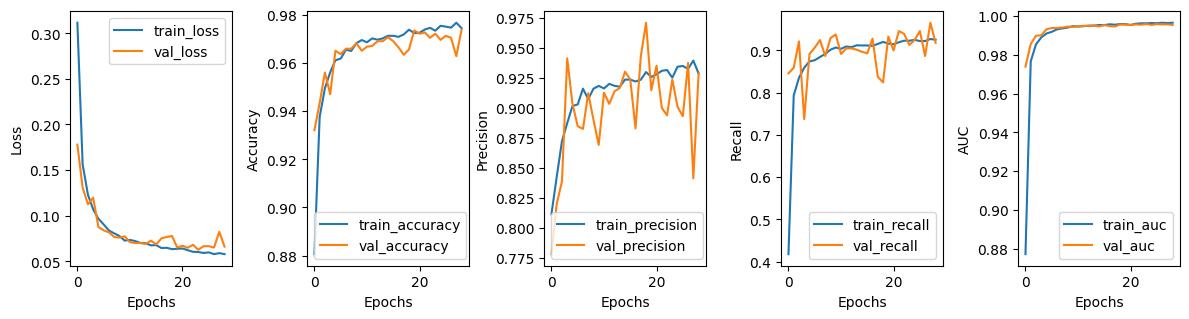

In [54]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(2, 5, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 5, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 5, 3)
plt.plot(history.history['precision_2'], label='train_precision')
plt.plot(history.history['val_precision_2'], label='val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 5, 4)
plt.plot(history.history['recall_2'], label='train_recall')
plt.plot(history.history['val_recall_2'], label='val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(2, 5, 5)
plt.plot(history.history['auc_2'], label='train_auc')
plt.plot(history.history['val_auc_2'], label='val_auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

Test:

In [55]:
y_pred = model_lstm.predict(X_test)

319/319 [==============================] - 1s 2ms/step


Accuracy, F1-score, Recall and Precision:

In [56]:
y_pred_classes = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test_class, y_pred_classes)
f1 = f1_score(y_test_class, y_pred_classes)
recall = recall_score(y_test_class, y_pred_classes)
precision = precision_score(y_test_class, y_pred_classes)

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.7667712828560219
F1-score: 0.41109460128776626
Recall: 0.28298670303443574
Precision: 0.751131221719457


Confusion Matrix:

Normalized confusion matrix


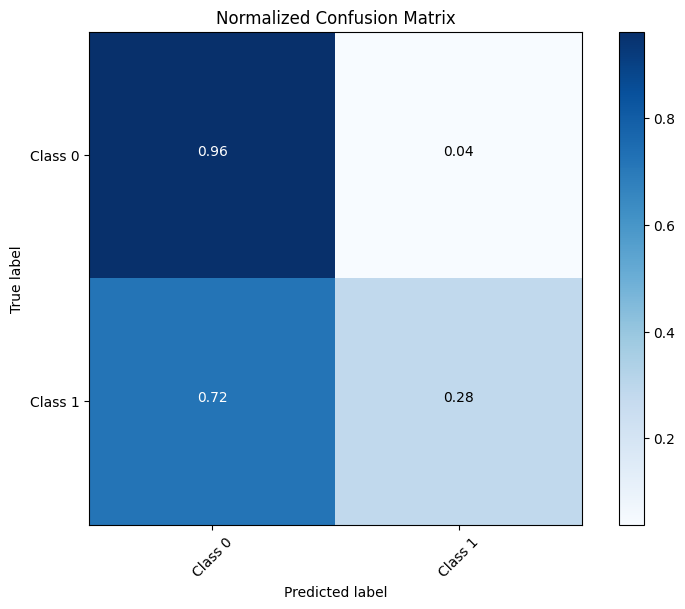

In [57]:
conf_matrix = confusion_matrix(y_test_class, y_pred_classes)

class_labels = ["Class 0", "Class 1"]

plot_confusion_matrix(conf_matrix, classes=class_labels, normalize=True, title='Normalized Confusion Matrix')

plt.show()

ROC:

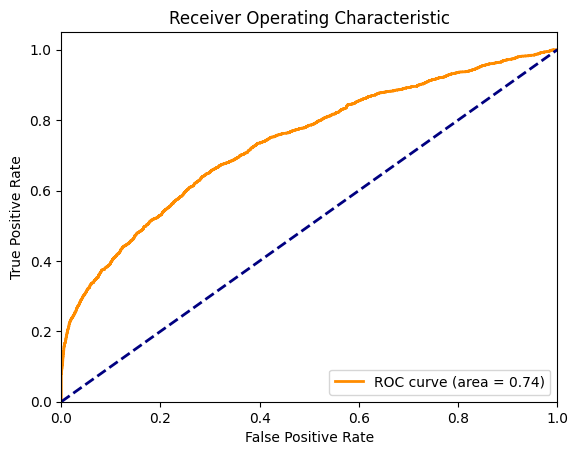

In [58]:
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##CNN for Regression:

In [59]:
import tensorflow as tf

input_shape = (30, 18)

model_cnn_regression = tf.keras.Sequential([
    tf.keras.layers.Reshape((30, 18, 1), input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model_cnn_regression.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

model_cnn_regression.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 30, 18, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 16, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 8, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 6, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 3, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)             

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

X_train_reg = np.array(X_train_reg)
y_train_reg = np.array(y_train_reg)

X_val_reg = np.array(X_val_reg)
y_val_reg = np.array(y_val_reg)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_cnn_regression.fit(X_train_reg, y_train_reg, epochs=100, batch_size=32, validation_data=(X_val_reg, y_val_reg), callbacks = [early_stopping])

Epoch 1/100
444/444 [==============================] - 4s 6ms/step - loss: 1106.3325 - mse: 1106.3325 - val_loss: 557.2188 - val_mse: 557.2188
Epoch 2/100
444/444 [==============================] - 2s 5ms/step - loss: 486.7242 - mse: 486.7242 - val_loss: 422.3188 - val_mse: 422.3188
Epoch 3/100
444/444 [==============================] - 2s 4ms/step - loss: 389.8688 - mse: 389.8688 - val_loss: 483.7892 - val_mse: 483.7892
Epoch 4/100
444/444 [==============================] - 2s 4ms/step - loss: 313.0812 - mse: 313.0812 - val_loss: 367.9586 - val_mse: 367.9586
Epoch 5/100
444/444 [==============================] - 2s 4ms/step - loss: 280.0848 - mse: 280.0848 - val_loss: 250.2827 - val_mse: 250.2827
Epoch 6/100
444/444 [==============================] - 2s 4ms/step - loss: 264.7545 - mse: 264.7545 - val_loss: 252.6314 - val_mse: 252.6314
Epoch 7/100
444/444 [==============================] - 2s 4ms/step - loss: 254.5397 - mse: 254.5397 - val_loss: 762.2321 - val_mse: 762.2321
Epoch 8/100

In [61]:
X_test_class = np.array(X_test)
y_test_reg = np.array(y_test_reg)

y_pred_4 = model_cnn_regression.predict(X_test_class)

319/319 [==============================] - 1s 2ms/step


RMSE, MSE , MAE, MAPE:

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [63]:
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_4))
mse = mean_squared_error(y_test_reg, y_pred_4)
mae = mean_absolute_error(y_test_reg, y_pred_4)
mape = np.mean(np.abs((y_test_reg - y_pred_4) / y_test_reg)) / len(y_test_reg)

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)

<ipython-input-63-9b92be3b84cd>:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_reg - y_pred_4) / y_test_reg)) / len(y_test_reg)


RMSE: 38.97184455105633
MSE: 1518.804667711699
MAE: 30.754342420961272
MAPE: inf


RUL Plot:

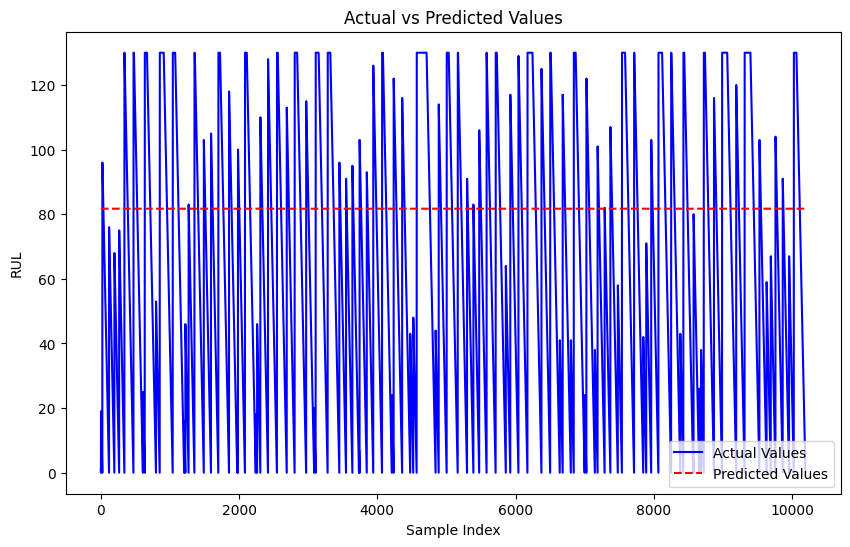

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_reg, label='Actual Values', color='b')
plt.plot(y_pred_3, label='Predicted Values', color='r', linestyle='--')

plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('RUL')

plt.legend()

plt.show()